In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

keras = tf.keras

In [8]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1/np.exp(3 * season_time))

def seasonality(time, period = 365, amplitude = 1, phase = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [25]:
def seq2seq_dataset(series, window_size, batch_size, shuffle_buffer = 1000):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda w: w.batch(batch_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda w: (w[:-1], w[1:]))
    return dataset.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift =1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


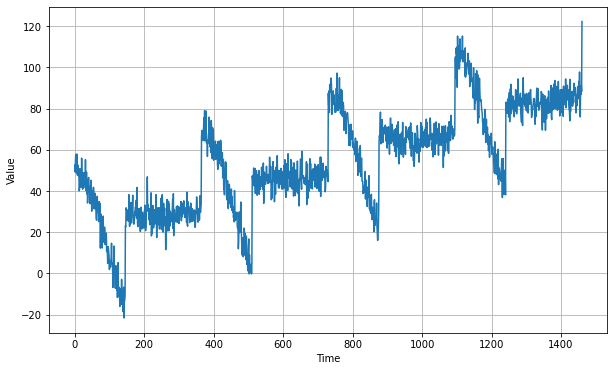

In [26]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [27]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Preprocessing With 1D-Convolutional Layers

In [31]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_dataset(series, window_size, batch_size=128)
valid_set = seq2seq_dataset(x_valid, window_size,
                                   batch_size=128)

model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape = [1,None,1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, dilation_rate =dilation_rate, padding = "causal", activation = "relu"))
model.add(tf.keras.layers.Conv1D(filters = 1, kernel_size = 1))
model.compile(optimizer = tf.keras.optimizers.SGD(lr = 1e-5,momentum=0.9),loss = tf.keras.losses.Huber(), metrics=['mae'])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('1D_CNN.h5', save_best_only=True)
early_stoping = tf.keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs = 500, validation_data=valid_set, callbacks=[early_stoping, model_checkpoint])

C:\Users\Mustafa Hasnain\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/500
11/11 [==============================] - 9s 606ms/step - loss: 53.1592 - mae: 53.6586 - val_loss: 78.0235 - val_mae: 78.5235
Epoch 2/500
11/11 [==============================] - 6s 562ms/step - loss: 53.1513 - mae: 53.6506 - val_loss: 78.0089 - val_mae: 78.5089
Epoch 3/500
11/11 [==============================] - 6s 535ms/step - loss: 53.1391 - mae: 53.6385 - val_loss: 77.9894 - val_mae: 78.4894
Epoch 4/500
11/11 [==============================] - 6s 537ms/step - loss: 53.1247 - mae: 53.6241 - val_loss: 77.9689 - val_mae: 78.4689
Epoch 5/500
11/11 [==============================] - 6s 540ms/step - loss: 53.1099 - mae: 53.6093 - val_loss: 77.9476 - val_mae: 78.4476
Epoch 6/500
11/11 [==============================] - 6s 538ms/step - loss: 53.0947 - mae: 53.5941 - val_loss: 77.9256 - val_mae: 78.4256
Epoch 7/500
11/11 [==============================] - 6s 536ms/step - loss: 53.0784 - mae: 53.5778 - val_loss: 77.9010 - val_mae: 78.4010
Epoch 8/500
11/11 [======================

11/11 [==============================] - 6s 539ms/step - loss: 47.5335 - mae: 48.0330 - val_loss: 69.3231 - val_mae: 69.8231
Epoch 61/500
11/11 [==============================] - 6s 533ms/step - loss: 46.8811 - mae: 47.3806 - val_loss: 68.2748 - val_mae: 68.7748
Epoch 62/500
11/11 [==============================] - 6s 535ms/step - loss: 46.1075 - mae: 46.6070 - val_loss: 67.0263 - val_mae: 67.5263
Epoch 63/500
11/11 [==============================] - 6s 554ms/step - loss: 45.1810 - mae: 45.6804 - val_loss: 65.5305 - val_mae: 66.0305
Epoch 64/500
11/11 [==============================] - 6s 539ms/step - loss: 44.0619 - mae: 44.5611 - val_loss: 63.6954 - val_mae: 64.1954
Epoch 65/500
11/11 [==============================] - 6s 538ms/step - loss: 42.6839 - mae: 43.1829 - val_loss: 61.4304 - val_mae: 61.9304
Epoch 66/500
11/11 [==============================] - 6s 535ms/step - loss: 40.9762 - mae: 41.4750 - val_loss: 58.5916 - val_mae: 59.0916
Epoch 67/500
11/11 [===========================

Epoch 121/500
11/11 [==============================] - 6s 548ms/step - loss: 5.3263 - mae: 5.8082 - val_loss: 5.4447 - val_mae: 5.9237
Epoch 122/500
11/11 [==============================] - 7s 638ms/step - loss: 5.3262 - mae: 5.8081 - val_loss: 5.4439 - val_mae: 5.9233
Epoch 123/500
11/11 [==============================] - 6s 555ms/step - loss: 5.3261 - mae: 5.8080 - val_loss: 5.4446 - val_mae: 5.9236
Epoch 124/500
11/11 [==============================] - 8s 685ms/step - loss: 5.3261 - mae: 5.8080 - val_loss: 5.4450 - val_mae: 5.9238
Epoch 125/500
11/11 [==============================] - 8s 671ms/step - loss: 5.3261 - mae: 5.8081 - val_loss: 5.4440 - val_mae: 5.9233
Epoch 126/500
11/11 [==============================] - 7s 624ms/step - loss: 5.3261 - mae: 5.8080 - val_loss: 5.4448 - val_mae: 5.9237
Epoch 127/500
11/11 [==============================] - 7s 605ms/step - loss: 5.3260 - mae: 5.8079 - val_loss: 5.4443 - val_mae: 5.9234
Epoch 128/500
11/11 [==============================] - 

In [32]:
model = tf.keras.models.load_model('1D_CNN.h5')

In [33]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

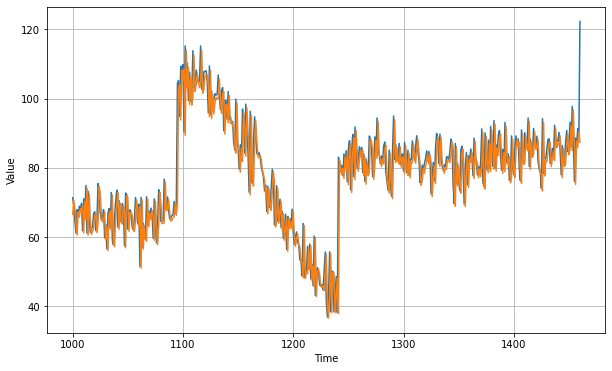

In [34]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [37]:
error = keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()
error

array([15.755734 , 13.825019 , 14.836758 , 17.290655 , 19.835518 ,
       15.377254 , 16.216291 , 14.8701725, 15.518747 , 14.50654  ,
       19.333763 , 13.925239 , 16.75176  , 12.592255 , 19.870827 ,
       13.123103 , 16.70594  , 19.683674 , 19.033524 , 18.417326 ,
       15.985049 , 15.696977 , 19.312225 , 17.335625 , 12.434972 ,
       13.070711 , 15.881361 , 17.076473 , 16.80021  , 15.364965 ,
       20.926342 , 18.015835 , 23.550169 , 15.900326 , 15.220081 ,
       18.765728 , 13.253645 , 21.612272 , 22.572857 , 16.32595  ,
       14.235068 , 13.0221815, 18.554113 , 14.139189 , 17.070251 ,
       17.49717  , 14.527188 , 15.049871 , 22.83544  , 13.312841 ,
       13.475934 , 19.001116 , 15.650173 , 15.373317 , 15.999006 ,
       18.643208 , 19.073067 , 16.81056  , 13.789591 , 15.160696 ,
       17.902792 , 14.597631 , 27.97971  , 13.781517 , 23.15574  ,
       17.776289 , 20.578144 , 21.252155 , 13.70121  , 18.06017  ,
       15.509329 , 16.6263   , 15.138801 , 16.216463 , 21.0385